In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

import pickle

#### Lecture et préparation des données éCO2mix et des données de prix spot

In [47]:
eco2mix = pd.read_csv("../data/eCO2mix_RTE_En-cours-Consolide.csv", sep="\t", encoding="latin-1", index_col=False).iloc[:-1]
eco2mix["Datetime"] = pd.to_datetime(eco2mix.Date + " " + eco2mix.Heures)
# eco2mix.drop(["Date", "Heures"], inplace=True, axis=1)

spot = pd.read_csv("../data/France.csv", sep=",", parse_dates=[-3,-2]).set_index("Datetime (Local)")

In [48]:
# Merge both dataframes on time
df = pd.merge(eco2mix, spot["Price (EUR/MWhe)"], left_on="Datetime", right_index=True).reset_index(drop=True)

# Drop columns which we will not use as predictors
df.drop(["Périmètre", "Nature", " Stockage batterie", "Déstockage batterie", "Datetime", "Date", "Heures"], axis=1, inplace=True)

# Check NaNs
df.isna().sum()

Consommation                            0
Prévision J-1                           0
Prévision J                             0
Fioul                                   0
Charbon                                 0
Gaz                                     0
Nucléaire                               0
Eolien                                  0
Solaire                                 0
Hydraulique                             0
Pompage                                 0
Bioénergies                             0
Ech. physiques                          0
Taux de Co2                             0
Ech. comm. Angleterre                   0
Ech. comm. Espagne                      0
Ech. comm. Italie                       0
Ech. comm. Suisse                       0
Ech. comm. Allemagne-Belgique           0
Fioul - TAC                             0
Fioul - Cogén.                          0
Fioul - Autres                          0
Gaz - TAC                               0
Gaz - Cogén.                      

In [49]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(df.drop("Price (EUR/MWhe)", axis=1),
                                                    df["Price (EUR/MWhe)"],
                                                    test_size=0.2)

# Standardization (useful since the "Tau de CO2" predictor does not have the same dimension as the rest)
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

#### Choix et entraînement des modèles
##### Régression linéaire

In [50]:
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


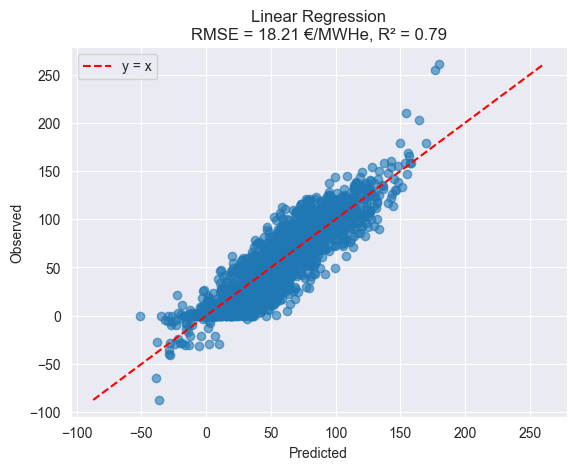

In [51]:
preds = linear_reg.predict(X_test)

rmse = mean_squared_error(y_test, preds)**0.5
r2 = r2_score(y_test, preds)

plt.scatter(preds, y_test, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', label='y = x')

plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.title(f"Linear Regression\nRMSE = {rmse:.2f} €/MWHe, R² = {r2:.2f}")

plt.legend()
plt.show()

##### Random Forest

In [52]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


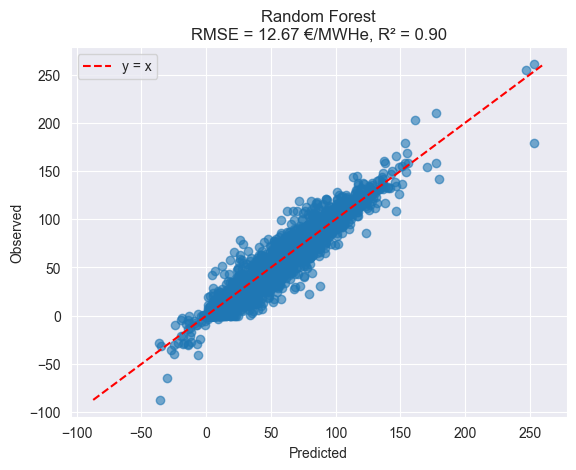

In [53]:
preds = rf.predict(X_test)

rmse = mean_squared_error(y_test, preds)**0.5
r2 = r2_score(y_test, preds)

plt.scatter(preds, y_test, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', label='y = x')

plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.title(f"Random Forest\nRMSE = {rmse:.2f} €/MWHe, R² = {r2:.2f}")

plt.legend()
plt.show()

#### Save models

In [ ]:
linear_reg.feature_names_in_ = df.drop("Price (EUR/MWhe)", axis=1).columns
rf.feature_names_in_ = df.drop("Price (EUR/MWhe)", axis=1).columns

with open('scaler.pkl','wb') as f:
    pickle.dump(scaler, f)

with open('linear_regressor.pkl','wb') as f:
    pickle.dump(linear_reg, f)

with open('random_forest_regressor.pkl','wb') as f:
    pickle.dump(rf, f)